In [ ]:
import pandas as pd           
import praw                   
import re                     
import datetime as dt
import seaborn as sns
import requests
import json
import sys
import time
## acknowledgements
'''
https://stackoverflow.com/questions/48358837/pulling-reddit-comments-using-python-praw-and-creating-a-dataframe-with-the-resu
https://www.reddit.com/r/redditdev/comments/2e2q2l/praw_downvote_count_always_zero/
https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91

For navigating pushshift: https://github.com/Watchful1/Sketchpad/blob/master/postDownloader.py

# traffic = reddit.subreddit(subreddit).traffic() is not available to us, sadly.
'''

with open("API.env") as file:
    exec(file.read())

reddit = praw.Reddit(
  client_id = client_id,
  client_secret = client_secret,
  user_agent = user_agent
)

In [255]:
'''
Some helper functions for the reddit API.
'''

def extract_num_rewards(awardings_data):
    return sum( x["count"] for x in awardings_data)


In [ ]:
'''
Code for getting all submissions between certain date time
'''

def convert_to_utc(date):
    return int(date.replace(tzinfo=dt.timezone.utc).timestamp())

def get_all_submissions(start_time, end_time, subreddit):
    end = end_time
    df = pd.DataFrame()
    while end > start_time:
        time.sleep(1) # Requests are rate limited
        print(f"Target time: {start_time}, current end point {end}, remaining {end - start_time}")

        url = f"https://api.pushshift.io/reddit/submission/search/?after={start_time}&before={end}&sort_type=created_utc&sort=desc&subreddit={subreddit}&limit=1000"

        data = requests.get(url)
        
        
        if data.headers['Content-Type'] == 'application/json; charset=UTF-8':
            data_json = data.json()
            if len(data_json['data']) == 0:
                # break if there is no returned data
                break

            temp_df = pd.DataFrame(data_json['data'])
            end = min(temp_df.created_utc) 
            df = df.append(temp_df, ignore_index = True)
        else:
            print(data.headers['Content-Type']) 
            
    # Get the current score from praw
    print(f"Got {len(df)} submissions.")
    print("Getting the updated values.")

    scores = []
    total_awards_received = []
    ratios = []

    # Based on this: https://www.reddit.com/r/redditdev/comments/aoe4pk/praw_getting_multiple_submissions_using_by_id/
    ids2 = [i if i.startswith('t3_') else f't3_{i}' for i in list(df.id)]
    for submission in reddit.info(ids2): # Makes a single call to the PRAW API, much faster than doing them one by one.
        scores.append(submission.score)
        total_awards_received.append(extract_num_rewards(submission.all_awardings))
        ratios.append( submission.upvote_ratio)

    df['score'], df['total_awards_received'], df['upvote_ratio'] = scores, total_awards_received, ratios
        
    return df

subreddit_df = pd.DataFrame()

start = dt.datetime(2021, 1,1)
end = dt.datetime(2021, 5, 7) #dt.datetime.now()
delta = dt.timedelta(days=1)
window_left = start
window_right = start + delta

while window_right < end:
    # Decided to go day by day to avoid losing data due to crashing partway through
    print(f"Processing {window_left} to {window_right}")
    df = get_all_submissions(convert_to_utc(window_left), convert_to_utc(window_right), "wallstreetbets")
    df.to_pickle(f"Data/wsb_start{convert_to_utc(window_left)}.pkl")
    subreddit_df = subreddit_df.append(df, ignore_index = True)
    window_left += delta
    window_right += delta

subreddit_df.to_pickle("Data/2021wsb.pkl")

Processing 2021-01-01 00:00:00 to 2021-01-02 00:00:00
Target time: 1609459200, current end point 1609545600, remaining 86400
Target time: 1609459200, current end point 1609534069, remaining 74869
Target time: 1609459200, current end point 1609521526, remaining 62326
Target time: 1609459200, current end point 1609503860, remaining 44660
Target time: 1609459200, current end point 1609480549, remaining 21349
Target time: 1609459200, current end point 1609467221, remaining 8021
Target time: 1609459200, current end point 1609459326, remaining 126
Got 588 submissions.
Getting the updated values.
Processing 2021-01-02 00:00:00 to 2021-01-03 00:00:00
Target time: 1609545600, current end point 1609632000, remaining 86400
Target time: 1609545600, current end point 1609619090, remaining 73490
Target time: 1609545600, current end point 1609611159, remaining 65559
Target time: 1609545600, current end point 1609602553, remaining 56953
Target time: 1609545600, current end point 1609583413, remaining 

Processing 2021-01-10 00:00:00 to 2021-01-11 00:00:00
Target time: 1610236800, current end point 1610323200, remaining 86400
Target time: 1610236800, current end point 1610313570, remaining 76770
Target time: 1610236800, current end point 1610305228, remaining 68428
Target time: 1610236800, current end point 1610295506, remaining 58706
Target time: 1610236800, current end point 1610277466, remaining 40666
Target time: 1610236800, current end point 1610254489, remaining 17689
Target time: 1610236800, current end point 1610243322, remaining 6522
Target time: 1610236800, current end point 1610236823, remaining 23
Got 665 submissions.
Getting the updated values.
Processing 2021-01-11 00:00:00 to 2021-01-12 00:00:00
Target time: 1610323200, current end point 1610409600, remaining 86400
Target time: 1610323200, current end point 1610403297, remaining 80097
Target time: 1610323200, current end point 1610399685, remaining 76485
Target time: 1610323200, current end point 1610395862, remaining 7

Target time: 1610668800, current end point 1610732025, remaining 63225
Target time: 1610668800, current end point 1610730792, remaining 61992
Target time: 1610668800, current end point 1610729218, remaining 60418
Target time: 1610668800, current end point 1610727869, remaining 59069
Target time: 1610668800, current end point 1610726470, remaining 57670
Target time: 1610668800, current end point 1610725136, remaining 56336
Target time: 1610668800, current end point 1610724058, remaining 55258
Target time: 1610668800, current end point 1610723052, remaining 54252
Target time: 1610668800, current end point 1610722026, remaining 53226
Target time: 1610668800, current end point 1610720555, remaining 51755
Target time: 1610668800, current end point 1610718451, remaining 49651
Target time: 1610668800, current end point 1610715514, remaining 46714
Target time: 1610668800, current end point 1610711791, remaining 42991
Target time: 1610668800, current end point 1610705861, remaining 37061
Target

Target time: 1611100800, current end point 1611166298, remaining 65498
Target time: 1611100800, current end point 1611164584, remaining 63784
Target time: 1611100800, current end point 1611163000, remaining 62200
Target time: 1611100800, current end point 1611161534, remaining 60734
Target time: 1611100800, current end point 1611160225, remaining 59425
Target time: 1611100800, current end point 1611159135, remaining 58335
Target time: 1611100800, current end point 1611157584, remaining 56784
Target time: 1611100800, current end point 1611155701, remaining 54901
Target time: 1611100800, current end point 1611154458, remaining 53658
Target time: 1611100800, current end point 1611152738, remaining 51938
Target time: 1611100800, current end point 1611149790, remaining 48990
Target time: 1611100800, current end point 1611146117, remaining 45317
Target time: 1611100800, current end point 1611141074, remaining 40274
Target time: 1611100800, current end point 1611134777, remaining 33977
Target

Target time: 1611273600, current end point 1611289362, remaining 15762
Target time: 1611273600, current end point 1611286184, remaining 12584
Target time: 1611273600, current end point 1611283779, remaining 10179
Target time: 1611273600, current end point 1611281108, remaining 7508
Target time: 1611273600, current end point 1611278410, remaining 4810
Target time: 1611273600, current end point 1611276529, remaining 2929


In [ ]:
'''
Displaying some of that data
'''


wsb_cleaned = df[['title', 'id', 'created_utc', 'author_fullname', 'is_self', 'score', 'upvote_ratio', 'total_awards_received', 'selftext', 'url']]
wsb_cleaned.sort_values(by = "score", ascending = False).head(10)

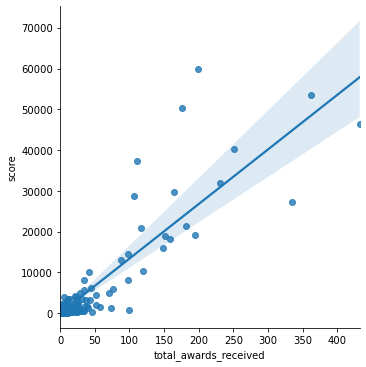

In [326]:
'''
Plotting awards against score
'''

sns.lmplot( data = wsb_cleaned, x = "total_awards_received", y = "score")